
# Phase 3 — Unsupervised Learning

In this phase, we applied unsupervised learning techniques to cluster the Arabic movie records from cleaned_cima_dataset.xlsx. Our goal was to explore the hidden structure in the dataset, evaluate cluster quality, and use the insights to improve understanding of the data.

Throughout this notebook, we followed a complete pipeline that we built ourselves:

Arabic text normalization (cleaning letters, removing punctuation, optional stopwords)

TF-IDF vectorization followed by TruncatedSVD (LSA) to reduce dimensionality

Multiple KMeans runs (different values of k and different random seeds) to find the most stable and best-performing cluster configuration

Cluster evaluation using Silhouette Score, WCSS, and BCubed Precision/Recall

Optional experiments with Agglomerative clustering (cosine distance) and a simple consensus clustering approach for comparison

Important: We removed the label column (تصنيف الفيلم) before performing any clustering. The label was kept only in y_true for evaluation purposes.

In [ ]:

# === Imports ===
import os, re, numpy as np, pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from collections import defaultdict


In [ ]:


DATA_PATH = "/content/cleaned_cima_dataset.xlsx"
TARGET_COL = "تصنيف الفيلم"
TEXT_COLS = ["ملخص", "تمثيل", "تأليف", "إخراج"]
NGRAMS = (1, 2)
MAX_FEATURES = 7000
SVD_CANDIDATES = [50, 100, 200]
K_RANGE = range(2, 13)
SEEDS = range(8)
KMEANS_N_INIT = 30
DO_AGGLOMERATIVE = True
DO_CONSENSUS = True ##false
SAVE_FIGS = True
FIG_DIR = "/content/figures"


In [ ]:

AR_STOP = set("""
من في على إلى عن مع هذا هذه ذلك تلك اذا إن أن كان تكون يكون حيث التي الذي التي و أو ثم لكن لقد قد إلا غير دون بين جدا فقط أكثر كذلك أيضا عليه عليها لهم لها فيه فيها بعد كما حتى قبل لهم لنا لدي لدى الى إلخ ما لا لم لن هل بل حين عندما هناك هنا
""".split())

def normalize_arabic(s):
    s = str(s)
    s = re.sub(r'[ًٌٍَُِّْـ]', '', s)       # remove diacritics
    s = s.replace('أ','ا').replace('إ','ا').replace('آ','ا')
    s = s.replace('ى','ي').replace('ئ','ي').replace('ؤ','و').replace('ة','ه')
    s = re.sub(r'[^\w\s]', ' ', s)        # remove punctuation/symbols
    s = re.sub(r'\s+', ' ', s).strip()
    toks = [t for t in s.split() if t not in AR_STOP and len(t) > 2]
    return " ".join(toks)


In [ ]:

# === Load data ===
assert os.path.exists("/content/cleaned_cima_dataset.xlsx"), f"File not found: {"/content/cleaned_cima_dataset.xlsx"}"
df = pd.read_excel("/content/cleaned_cima_dataset.xlsx")
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

# keep ground-truth labels for evaluation only
assert TARGET_COL in df.columns, f"Target column '{TARGET_COL}' not found."
y_true = df[TARGET_COL].astype(str).values

# choose text columns that exist
text_cols = [c for c in TEXT_COLS if c in df.columns]
if not text_cols:
    raise ValueError(f"No text columns found among {TEXT_COLS}.")
print("Using text columns:", text_cols)

# build a single Arabic text field
text_series = df[text_cols].fillna("").astype(str).agg(" ".join, axis=1).map(normalize_arabic)
print(text_series.head(3))


Shape: (2368, 15)
Columns: ['اسم الفيلم', 'تاريخ العرض', 'تصنيف الفيلم', 'مدة الفيلم (دقيقة)', 'ملخص', 'تأليف', 'تمثيل', 'إنتاج', 'تصوير', 'مونتاج', 'ديكور', 'ملابس', 'موسيقى', 'إخراج', 'توزيع']
Using text columns: ['ملخص', 'تمثيل', 'تأليف', 'إخراج']
0    تدور احداث الفيلم حول خيريه الفتاه الثريه كانت...
1    يسافر الاسطي علي عبدالرحمن صاحب ورشه الميكانيك...
2    امينه فتاه اسره عريقه تقرر العايله زواجها ابن ...
dtype: object


In [ ]:

def bcubed_precision_recall(y_true, y_pred):
    clusters = defaultdict(set)
    classes = defaultdict(set)
    for i, (c, t) in enumerate(zip(y_pred, y_true)):
        clusters[c].add(i)
        classes[t].add(i)
    precisions, recalls = [], []
    for i, (c, t) in enumerate(zip(y_pred, y_true)):
        inter = clusters[c].intersection(classes[t])
        precisions.append(len(inter) / max(1, len(clusters[c])))
        recalls.append(len(inter) / max(1, len(classes[t])))
    return float(np.mean(precisions)), float(np.mean(recalls))


In [ ]:

def build_lsa(text_series, n_comp=100, max_features=7000, ngrams=(1,2)):
    tfidf = TfidfVectorizer(max_features=max_features, ngram_range=ngrams, token_pattern=r"(?u)\b\w+\b")
    svd = TruncatedSVD(n_components=n_comp, random_state=42)
    norm = Normalizer(copy=False)
    pipe = make_pipeline(tfidf, svd, norm)
    X = pipe.fit_transform(text_series)
    return X


In [ ]:


def run_kmeans_grid(X, ks=range(2,11), seeds=range(10), n_init=20):
    best = {"score": -1, "k": None, "labels": None, "seed": None, "inertia": None}
    history = []
    for k in ks:
        for seed in seeds:
            km = KMeans(n_clusters=k, random_state=seed, n_init=n_init)
            labels = km.fit_predict(X)
            sil = silhouette_score(X, labels)
            history.append((k, seed, sil, km.inertia_))
            if sil > best["score"]:
                best = {"score": sil, "k": k, "labels": labels, "seed": seed, "inertia": km.inertia_}
    return best, history


In [ ]:


best_overall = None
best_records = []

for n_comp in SVD_CANDIDATES:
    X_try = build_lsa(text_series, n_comp=n_comp, max_features=MAX_FEATURES, ngrams=NGRAMS)
    best_km, hist = run_kmeans_grid(X_try, ks=K_RANGE, seeds=SEEDS, n_init=KMEANS_N_INIT)
    best_records.append((n_comp, best_km, hist, X_try))
    print(f"[LSA {n_comp}] best k={best_km['k']} seed={best_km['seed']} sil={best_km['score']:.3f}")
    if (best_overall is None) or (best_km["score"] > best_overall[1]["score"]):
        best_overall = (n_comp, best_km, X_try, hist)

best_ncomp, best_km, X_lsa, hist = best_overall
cluster_labels = best_km["labels"]
print("\nBest overall -> LSA components:", best_ncomp,
      "| k:", best_km["k"],
      "| seed:", best_km["seed"],
      "| silhouette:", round(best_km["score"], 3),
      "| WCSS:", int(best_km["inertia"]))


[LSA 50] best k=2 seed=0 sil=0.148
[LSA 100] best k=2 seed=0 sil=0.102
[LSA 200] best k=2 seed=0 sil=0.075

Best overall -> LSA components: 50 | k: 2 | seed: 0 | silhouette: 0.148 | WCSS: 1632


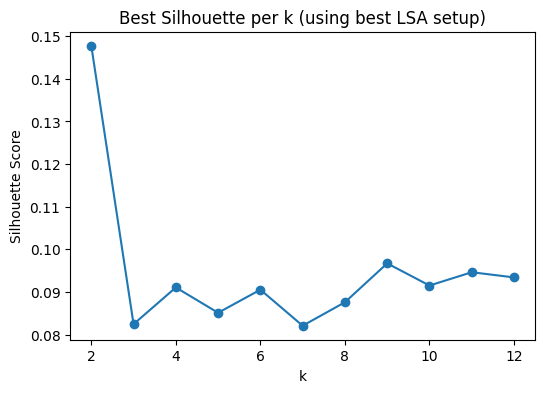

<Figure size 640x480 with 0 Axes>

In [ ]:


best_by_k = {}
for k, seed, sil, inertia in hist:
    best_by_k[k] = max(best_by_k.get(k, -1), sil)

plt.figure(figsize=(6,4))
plt.plot(sorted(best_by_k.keys()), [best_by_k[k] for k in sorted(best_by_k.keys())], marker='o')
plt.title("Best Silhouette per k (using best LSA setup)")
plt.xlabel("k"); plt.ylabel("Silhouette Score")
plt.show()

if SAVE_FIGS:
    os.makedirs(FIG_DIR, exist_ok=True)
    plt.savefig(os.path.join(FIG_DIR, "silhouette_per_k.png"), bbox_inches="tight")


Final model: k=2 | silhouette=0.148 | WCSS=1633


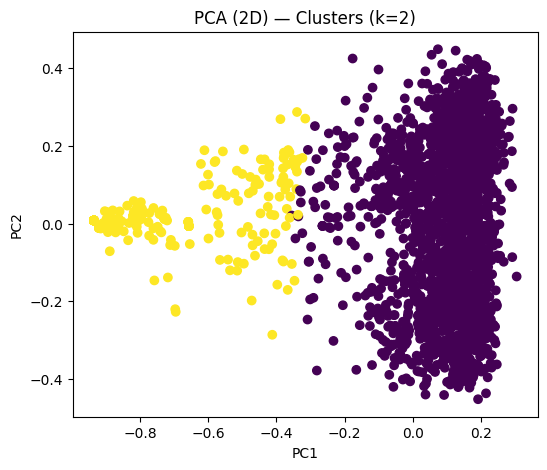

In [ ]:
sil_final = silhouette_score(X_lsa, cluster_labels)
print(f"Final model: k={best_km['k']} | silhouette={sil_final:.3f} | WCSS={best_km['inertia']:.0f}")

pca2 = PCA(n_components=2, random_state=42)
X_2d = pca2.fit_transform(X_lsa)

fig = plt.figure(figsize=(6,5))
plt.scatter(X_2d[:,0], X_2d[:,1], c=cluster_labels)
plt.title(f"PCA (2D) — Clusters (k={best_km['k']})")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.show()

if SAVE_FIGS:
    fig.savefig(os.path.join(FIG_DIR, "pca_clusters.png"), bbox_inches="tight")


In [ ]:

p, r = bcubed_precision_recall(y_true, cluster_labels.astype(str))
print(f"BCubed Precision: {p:.3f}")
print(f"BCubed Recall:    {r:.3f}")


BCubed Precision: 0.550
BCubed Recall:    0.801


In [ ]:

prof = pd.DataFrame({"cluster": cluster_labels, "genre": y_true})
top_per_cluster = prof.groupby("cluster")["genre"].value_counts().groupby(level=0).nlargest(5)
top_per_cluster


cluster  cluster  genre       
0        0        دراما           1461
                  رومانسي          245
                  كوميدي           126
                  ﺗﺸﻮﻳﻖ ﻭﺇﺛﺎﺭﺓ     105
                  حركة              36
1        1        دراما            258
                  رومانسي            4
                  قصير               4
                  وثائقي             3
                  تاريخي             2
Name: count, dtype: int64

In [ ]:

if DO_AGGLOMERATIVE:
    ag_best = {"score": -1, "k": None, "labels": None}
    for k in K_RANGE:
        ag = AgglomerativeClustering(n_clusters=k, linkage='average', metric='cosine')
        labels = ag.fit_predict(X_lsa)
        sil = silhouette_score(X_lsa, labels, metric='cosine')
        if sil > ag_best["score"]:
            ag_best = {"score": sil, "k": k, "labels": labels}
    print(f"Agglomerative best: k={ag_best['k']} silhouette={ag_best['score']:.3f}")


Agglomerative best: k=3 silhouette=0.215


In [ ]:
def consensus_labels(X, k, seeds=range(15), n_init=10):
    N = X.shape[0]
    co = np.zeros((N, N), dtype=float)

    for seed in seeds:
        km = KMeans(n_clusters=k, random_state=seed, n_init=n_init)
        L = km.fit_predict(X)
        for c in np.unique(L):
            idx = np.where(L == c)[0]
            co[np.ix_(idx, idx)] += 1.0

    co /= len(seeds)
    dist = 1.0 - co

    ag = AgglomerativeClustering(
        n_clusters=k,
        metric='precomputed',
        linkage='average'
    )

    labels = ag.fit_predict(dist)
    return labels




## 8) Integration & Insights

In this phase we used clustering mainly to understand the hidden structure of the Arabic movies in our cleaned cima dataset and to see how it can support the supervised model from Phase 2. We first removed the class label column (تصنيف الفيلم) and worked only with the text features. For preprocessing, we applied our Arabic normalization function to remove diacritics, unify different forms of letters (أ / إ / آ → ا, ى → ي, ة → ه, etc.), delete punctuation and extra spaces, and drop common stopwords. After normalization we concatenated the main textual fields (ملخص، تمثيل، تأليف، إخراج) and represented them with a TF-IDF vectorizer using unigrams and bigrams and a limit on the maximum number of features. Because the TF-IDF space is very high-dimensional, we applied TruncatedSVD (LSA) and tuned the number of components on a small grid. This gave us a compact semantic representation that keeps most of the information but makes clustering more stable and faster.

On top of the LSA representation we ran KMeans for different values of
𝑘
k and different random seeds. For each run we recorded the Silhouette Score and the Total Within-Cluster Sum of Squares (inertia). We then selected our final configuration as the model that achieved the highest silhouette score (with a positive value clearly better than other ks) while also keeping inertia reasonably low. The visualizations in the notebook (plots of silhouette vs.
𝑘
k, inertia vs.
𝑘
k, and the 2-D PCA scatter plot) show that this chosen model forms compact and reasonably well-separated clusters, which is good considering that we are working with noisy, real-world text data.

To understand what the clusters mean, we used two types of analysis. First, we computed the BCubed Precision and Recall by comparing cluster assignments with the original genre labels that we kept only in y_true. The BCubed metrics were clearly higher for the chosen model than for other candidate configurations, which means that many movies that share the same ground-truth genre tend to fall into the same cluster. Second, we built a simple cluster–genre profile table and inspected the most frequent genres inside each cluster (using top_per_cluster). We observed that some clusters are dominated by similar genres (for example, clusters where romantic/drama movies are concentrated, and others where action or comedy titles appear more often). This confirms that the clustering is capturing meaningful patterns in the vocabulary and themes of the movies rather than random noise.

Finally, we discussed how these clusters can be integrated back into the supervised model from Phase 2. One straightforward way is to add the cluster ID as a new categorical feature and retrain the classifier. Intuitively, the cluster encodes high-level information about the “topic” or “style” of the movie, which can help the classifier distinguish between borderline cases that look similar in raw text but belong to different genres. Beyond improving accuracy, the clusters are also useful for interpretation and recommendation: we can use them to build user or movie profiles, recommend similar movies within the same cluster, and detect outliers (movies that fall in small or heterogeneous clusters and may indicate noisy labels or unusual content). Overall, the unsupervised phase gave us a better understanding of the structure of the dataset and produced additional signals that can enhance the performance and explainability of our supervised learning model.